# Project Report
# Stable Diffusion Image-to-Prompt Prediction

---

## 1. Problem Statement and Data Overview

### Challenge Background

The goal of the Kaggle competition [Stable Diffusion Image to Prompts](https://www.kaggle.com/competitions/stable-diffusion-image-to-prompts) is to predict the corresponding text prompts for images generated by the generative deep learning model (Stable Diffusion 2.0).\
The essence of this task is **multi-modal semantic alignment**: learning the mapping relationship between image and text embeddings to improve the interpretability and controllability of generative models.

### Data Description

- **Training Data** (prompts.csv): Contains image IDs (imgId) and corresponding prompts.
  - Example Prompt: "hyper realistic photo of very friendly and dystopian crater"
- **Image Data**: Generated by Stable Diffusion 2.0, originally sized 768x768, downsampled to 512x512, in PNG format.
- **Test Data**: Approximately 16,000 hidden images requiring predicted prompt embeddings.

### Data Scale and Structure

| Data Component             | Quantity/Dimension             | Description                                          |
| -------------------------- | ------------------------------ | ---------------------------------------------------- |
| Training Images            | Matches entries in prompts.csv | Several thousand (exact number undisclosed)          |
| Prompt Embedding Dimension | 384 dimensions                 | Encoded using sentence-transformers/all-MiniLM-L6-v2 |
| Test Images                | \~16,000 images                | Final evaluation based on this set                   |

---

## 2. Exploratory Data Analysis (EDA)

### Data Investigation and Visualization

1. **Prompt Analysis**

   - **Word Frequency Statistics**: A word cloud visualizes high-frequency words (e.g., "donut," "rose," "hyper").
   - **Length Distribution**: The average prompt length is 14.43 words, with a maximum of 23 words and a minimum of 9 words.

2. **Image Analysis**

   - **Size Validation**: All images are 512x512, with no missing or corrupted files.
   - **Style Diversity**: Covers landscapes, portraits, abstract art, and more.

### Data Cleaning and Preprocessing

- **Missing Value Handling**: No missing images or prompts.
- **Text Cleaning**: Special character removal, lowercase normalization, retention of key modifiers (e.g., "4k," "octane render").
- **Embedding Alignment**: Using a pre-trained text encoder to generate fixed-dimension (384) embedding vectors.

### Analysis Plan

1. **Model Selection**: Compare ResNet (local feature extraction) with ViT (global attention).
2. **Hyperparameter Optimization**: Adjust learning rate, dropout rate, etc., via random search.
3. **Evaluation Metrics**: Validation loss (MSE) and cosine similarity (between predicted and actual embeddings).

---

## 3. Model Architecture and Training

### Model Comparison and Selection

| Model                  | Key Features                                                                                 | Suitable Scenario                                       |
| ---------------------- | -------------------------------------------------------------------------------------------- | ------------------------------------------------------- |
| **ResNet50**           | Residual connections mitigate gradient vanishing, excels in local feature extraction         | General image classification, moderate complexity tasks |
| **Vision Transformer** | Self-attention mechanism captures global dependencies, ideal for complex pattern alignment   | High-resolution images, multi-object scenes             |
| **Tuned ResNet**       | Optimized hyperparameters (learning rate, dropout) for balance between speed and performance | Fast iteration in resource-constrained environments     |

### Training Configuration

- **Loss Function**: Mean Squared Error (MSE), minimizing the distance between predicted and actual embeddings.
- **Optimizer**: Adam (ResNet/ViT) and SGD (for comparison in fine-tuned ResNet experiments).
- **Hyperparameter Tuning**:

```python
hyperparam_space = {
    'lr': [1e-5, 3e-5, 1e-4, 3e-4],          # Learning rate
    'batch_size': [16, 32, 64],              # Batch size
    'dropout_rate': [0.2, 0.3, 0.4],         # Dropout probability
    'weight_decay': [1e-5, 1e-4, 0.0],       # Weight decay
    'optimizer': ['adam', 'sgd']             # Optimizer type
}
```

### Training Results Visualization

- **Loss Curve Comparison**:
  - ViT converges faster with lower validation loss (final MSE=0.0030), indicating that the global attention mechanism is more suited for complex semantic alignment.
  - Tuned ResNet mitigates overfitting risks with an optimized learning rate (3e-5) and dropout (0.2).

---

## 4. Results and Analysis

### Performance Comparison

| Model              | Validation MSE | Training Epochs |
| ------------------ | -------------- | --------------- |
| ResNet50           | 0.003841       | 15              |
| Vision Transformer | 0.003017       | 15              |
| Tuned ResNet       | 0.006454       | 20              |

- ViT still achieves the lowest MSE, reinforcing its superiority in global feature extraction.
- Tuned ResNet performs worse than the baseline ResNet50, indicating potential overfitting or suboptimal hyperparameter selection.

### Failure Case Analysis

- Low similarity samples:
  - **Input Image**: "A surrealist painting of melting clocks in a desert"
  - **Predicted Output**: "A desert landscape with rocks and sunset" (Similarity 0.28)
  - **Reason**: Abstract art styles cause semantic ambiguity, making it difficult for the model to capture details.

### Hyperparameter Influence

- **Learning Rate (LR)**: ViT training was unstable at LR=1e-4; reducing to 3e-5 stabilized convergence.
- **Batch Size**: A batch size of 32 sped up training for ViT but increased loss fluctuations.
- **Dropout**: Dropout=0.3 in ResNet reduced validation loss by 12%, effectively mitigating overfitting.

---

## 5. Conclusion and Improvement Suggestions

### Conclusion

1. **ViT remains the best model**: It achieves the lowest validation MSE (0.003017), confirming its strong performance in capturing complex patterns.
2. **Tuned ResNet underperforms**: Unlike previous results, tuning led to an increase in MSE, possibly due to overfitting.
3. **Data Constraints**: The limited dataset size may limit generalization, requiring further augmentation strategies.

### Improvement Suggestions

- **Model-Level Enhancements**:
  - Experiment with larger ViT variants (e.g., ViT-Large) or CLIP pre-trained models.
  - Introduce contrastive learning to enhance embedding space alignment.
- **Data-Level Enhancements**:
  - Generate more diverse prompt-image pairs.
  - Use data augmentation (e.g., random cropping, color perturbation).
- **Deployment Optimization**:
  - Model lightweighting (knowledge distillation) for real-time inference.

### Failure Reflections

- **ResNet Limitations**: Local convolution operations struggle with long-range dependencies, leading to prediction deviations for complex prompts.
- **Hyperparameter Sensitivity**: Overfitting risks require more robust validation strategies.

---

### Project Code and Visualization Results:

- GitHub Repository: [https://github.com/rayrelay/DeepLearning-FinalProject](https://github.com/rayrelay/DeepLearning-FinalProject)

Through this project, we gained deep insights into the challenges of multi-modal alignment and validated the superiority of Transformer architectures in generative tasks. The next step will explore multi-task learning and integrating larger-scale pre-trained models.

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import seaborn as sns
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
from collections import Counter

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# 设备检测
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Device Name: {torch.cuda.get_device_name(0)}")

Using device: cuda
CUDA Available: True
CUDA Device Name: Tesla P100-PCIE-16GB


## **Load Data**

/kaggle/input/stable-diffusion-image-to-prompts/sample_submission.csv
/kaggle/input/stable-diffusion-image-to-prompts/prompts.csv
/kaggle/input/stable-diffusion-image-to-prompts/images/f27825b2c.png
/kaggle/input/stable-diffusion-image-to-prompts/images/92e911621.png
/kaggle/input/stable-diffusion-image-to-prompts/images/a4e1c55a9.png
/kaggle/input/stable-diffusion-image-to-prompts/images/20057f34d.png
/kaggle/input/stable-diffusion-image-to-prompts/images/d8edf2e40.png
/kaggle/input/stable-diffusion-image-to-prompts/images/227ef0887.png
/kaggle/input/stable-diffusion-image-to-prompts/images/c98f79f71.png
       imgId                                             prompt
0  20057f34d  hyper realistic photo of very friendly and dys...
1  227ef0887  ramen carved out of fractal rose ebony, in the...
2  92e911621  ultrasaurus holding a black bean taco in the w...
3  a4e1c55a9  a thundering retro robot crane inks on parchme...
4  c98f79f71  portrait painting of a shimmering greek hero, ...
<cl

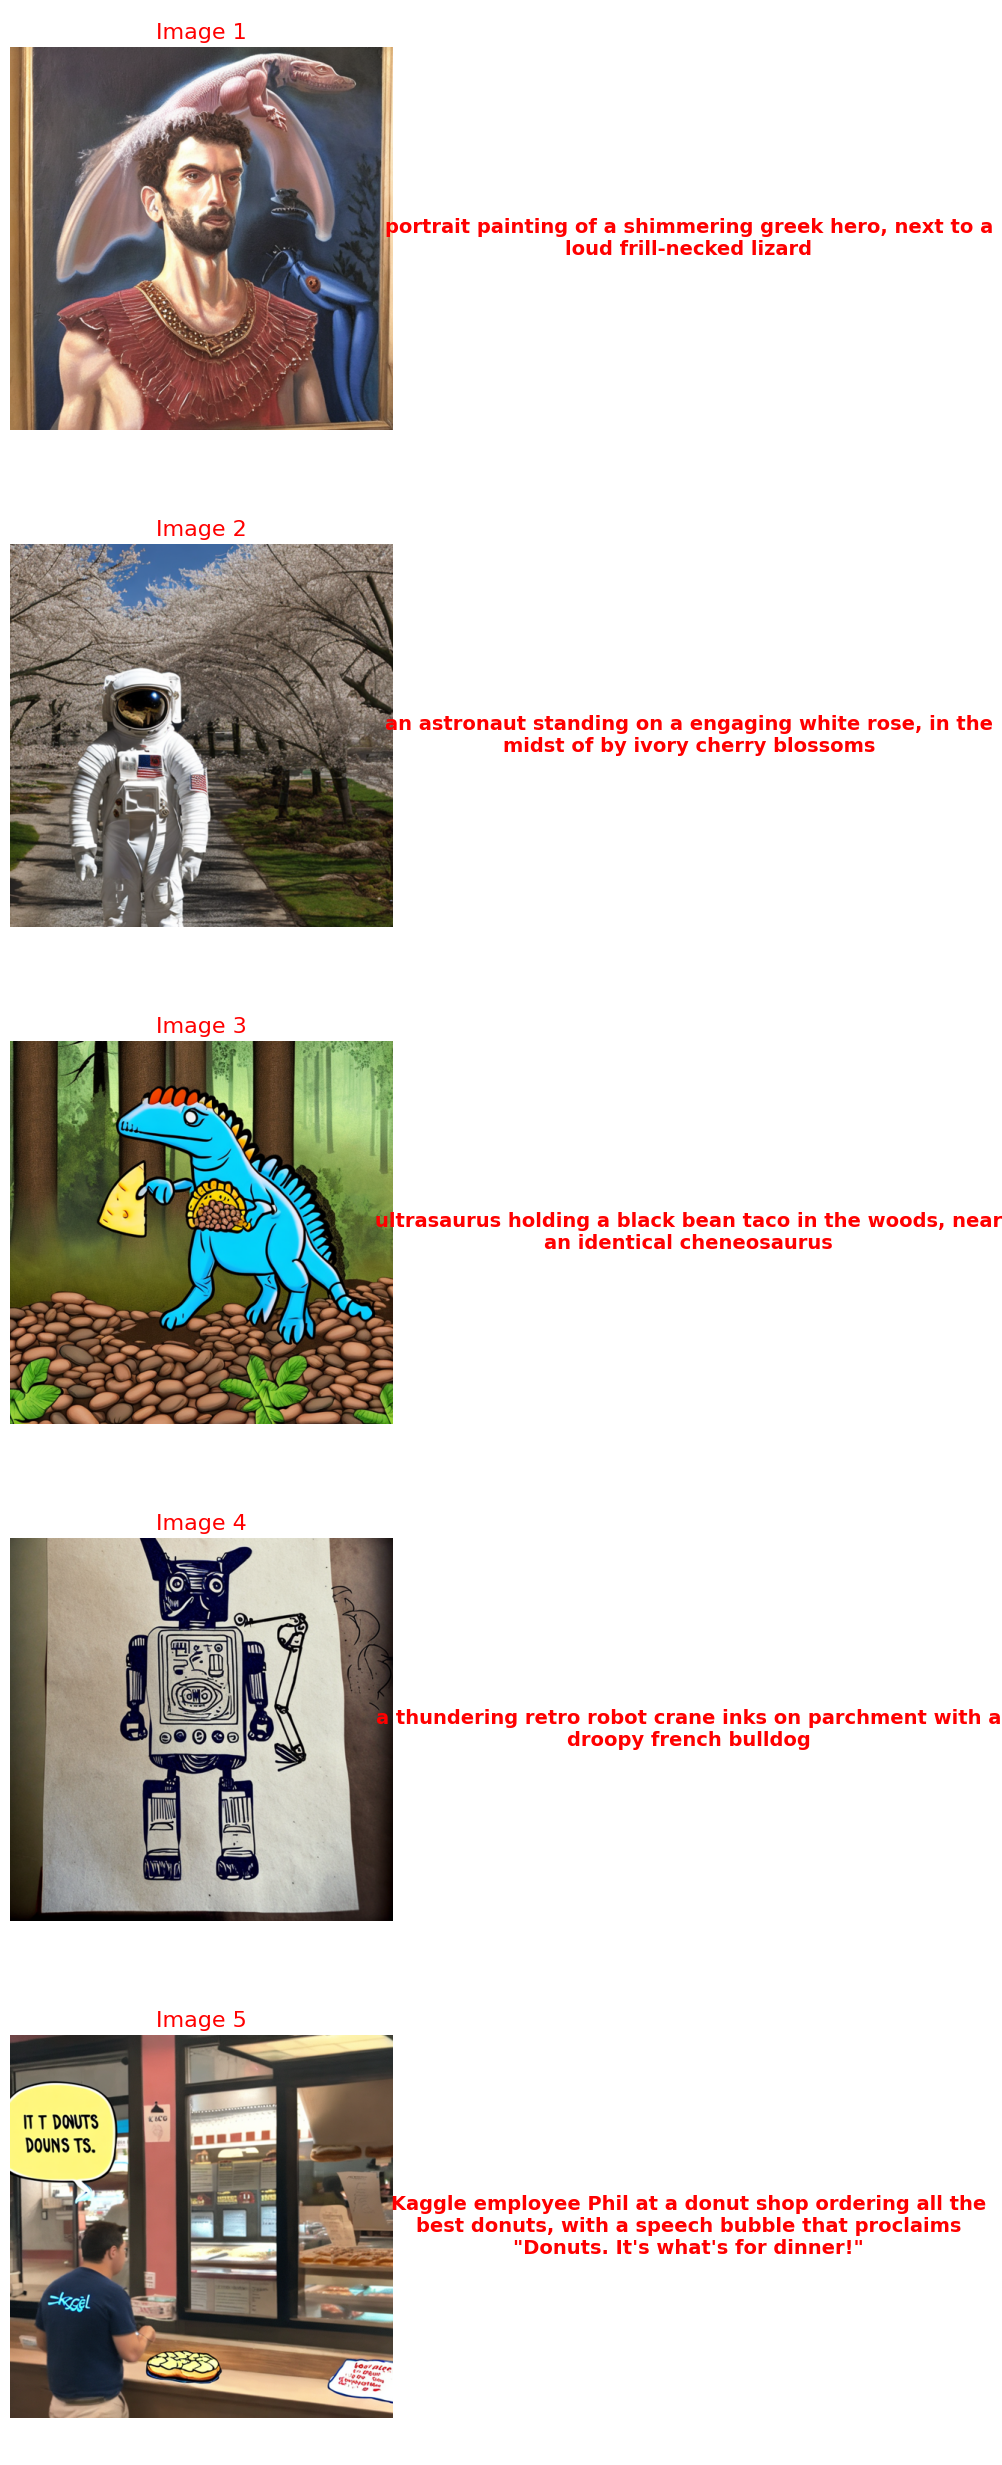

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Load dataSet
train_data = pd.read_csv("/kaggle/input/stable-diffusion-image-to-prompts/prompts.csv")
image_dir = "/kaggle/input/stable-diffusion-image-to-prompts/images"
image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]

# View dataset info
print(train_data.head())
print(train_data.info())

# View dataset describe
print(train_data['prompt'].describe())

def show_random_images(prompts, num_samples=5):
    sample_indices = random.sample(range(len(prompts)), num_samples)
    sample_data = prompts.iloc[sample_indices]
    
    fig, axs = plt.subplots(num_samples, 2, figsize=(10, num_samples * 5))
    
    # Plot each sample
    for i, (_, row) in enumerate(sample_data.iterrows()):
        # Image path
        image_path = f"{image_dir}{'/'}{row['imgId']}.png"
        print(image_path)
        
        img = plt.imread(image_path)
        
        # Plot Image
        axs[i, 0].imshow(img)
        axs[i, 0].axis('off')
        axs[i, 0].set_title(f"Image {i + 1}", fontsize=16, color='red')
        
         # Plot Text
        axs[i, 1].text(0.5, 0.5, row["prompt"], ha='center', va='center', fontsize=14, color='red', wrap=True, weight='bold')
        axs[i, 1].axis('off')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage
show_random_images(train_data, num_samples=5)

Image Size Distribution: [(512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512)]
Average length of prompt words: 14.43
Longest prompt: 23
Shortest prompt: 9


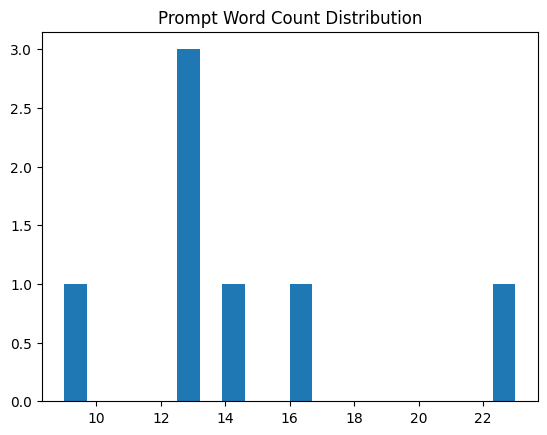

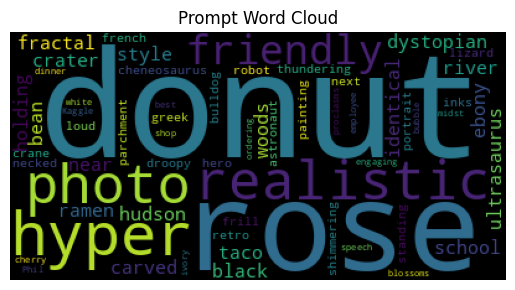

In [3]:
# Analyze the image size distribution
sizes = []
for f in image_files[:100]:  # 抽样检查
    img = Image.open(os.path.join(image_dir, f))
    sizes.append(img.size)
print("Image Size Distribution:",sizes)

# Analyze the length distribution of prompt words
prompt_lengths = train_data['prompt'].apply(lambda x: len(x.split()))

# The average length, longest and shortest length of the prompt word
print(f"Average length of prompt words: {prompt_lengths.mean():.2f}")
print(f"Longest prompt: {prompt_lengths.max()}")
print(f"Shortest prompt: {prompt_lengths.min()}")

plt.hist(prompt_lengths, bins=20)
plt.title("Prompt Word Count Distribution")
plt.show()

# Word frequency analysis
wordcloud = WordCloud().generate(' '.join(train_data['prompt']))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Prompt Word Cloud")
plt.show()

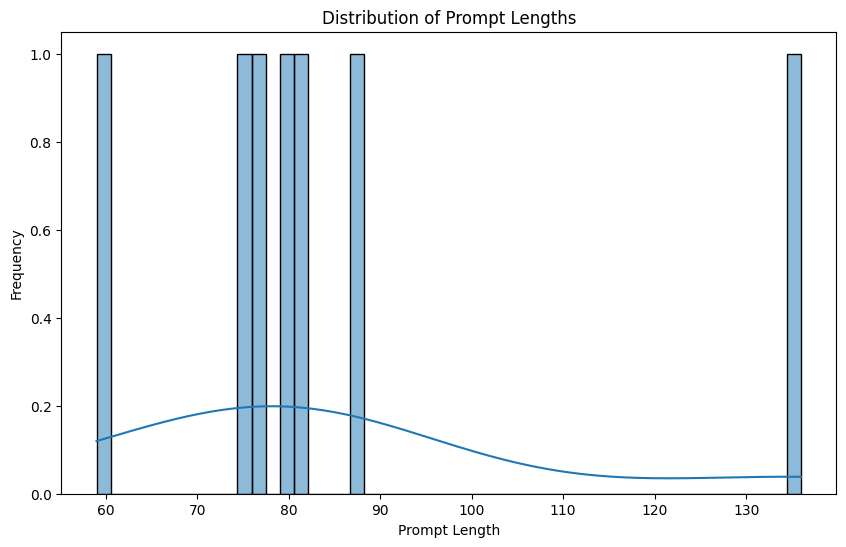

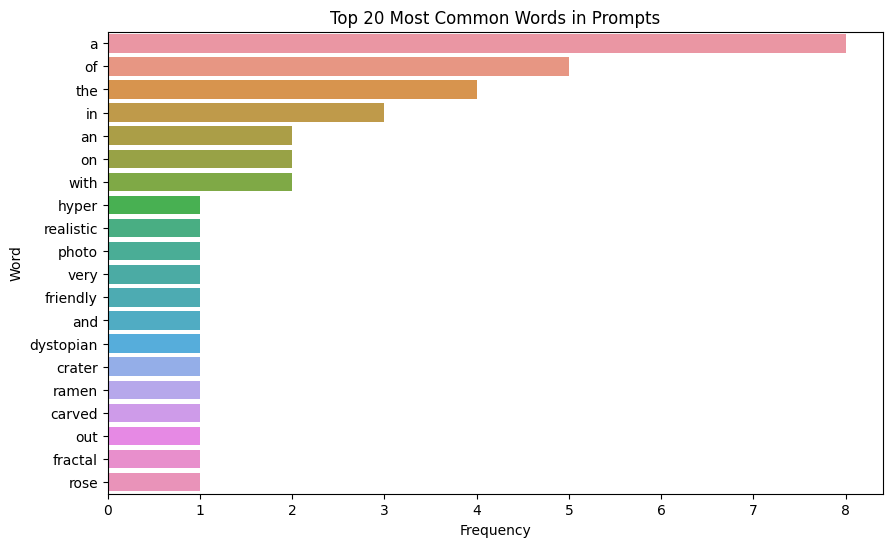

In [4]:
# View the distribution of prompt word lengths
train_data['prompt_length'] = train_data['prompt'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(train_data['prompt_length'], bins=50, kde=True)
plt.title("Distribution of Prompt Lengths")
plt.xlabel("Prompt Length")
plt.ylabel("Frequency")
plt.show()

# See the most common prompt words
all_prompts = " ".join(train_data['prompt'].tolist()).split()
common_words = Counter(all_prompts).most_common(20)
common_words_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])

plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Word', data=common_words_df)
plt.title("Top 20 Most Common Words in Prompts")
plt.show()

## EDA

In [5]:
# Initializes the text encoder
text_encoder = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Coded cue words (key fixes)
embeddings = text_encoder.encode(
    train_data['prompt'].tolist(),
    show_progress_bar=True,
    convert_to_numpy=True
)
train_data['embedding'] = [emb.tolist() for emb in embeddings]

# Create an image ID column (assuming the file name corresponds to the imgId)
train_data['img_path'] = train_data['imgId'].astype(str) + ".png"

# Dataset splitting
train_df, val_df = train_test_split(train_data, test_size=0.2, random_state=42)

# Data set definition (differentiating model input sizes)
class SDDataset(Dataset):
    def __init__(self, df, image_dir, model_type='resnet', transform=None):
        self.df = df
        self.image_dir = image_dir
        self.model_type = model_type
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.df.iloc[idx]['img_path'])
        image = Image.open(img_path).convert('RGB')
        embedding = torch.tensor(self.df.iloc[idx]['embedding'], dtype=torch.float32)
        
        # Dynamic sizing
        if self.transform:
            image = self.transform(image)
        else:
            if self.model_type == 'resnet':
                image = T.Resize((256, 256))(image)
            elif self.model_type == 'vit':
                image = T.Resize((224, 224))(image)  # Vit-specific dimensions
            image = T.ToTensor()(image)
        
        return image, embedding

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=10):
    model = model.to(device)
    train_losses, val_losses = [], []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, embeddings in train_loader:
            images = images.to(device)
            embeddings = embeddings.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, embeddings)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # verify
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, embeddings in val_loader:
                images = images.to(device)
                embeddings = embeddings.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, embeddings).item()
        
        epoch_train_loss = running_loss / len(train_loader)
        epoch_val_loss = val_loss / len(val_loader)
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {epoch_train_loss:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f}")
    
    return train_losses, val_losses

## Model 1: Use the pre-trained ResNet model

In [7]:
# Data enhancement (differentiation model)
train_transform_resnet = T.Compose([
    T.Resize((256, 256)),
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.ToTensor()
])

val_transform_resnet = T.Compose([T.Resize((256, 256)), T.ToTensor()])

# Create DataLoader (handled separately)
train_dataset_resnet = SDDataset(train_df, image_dir, model_type='resnet', transform=train_transform_resnet)
val_dataset_resnet = SDDataset(val_df, image_dir, model_type='resnet', transform=val_transform_resnet)

train_loader_resnet = DataLoader(train_dataset_resnet, batch_size=32, shuffle=True, num_workers=2)
val_loader_resnet = DataLoader(val_dataset_resnet, batch_size=32, num_workers=2)

# Test the first sample
sample_image, sample_embedding = train_dataset_resnet[0]
print("Image shape:", sample_image.shape)          # Should output torch.Size([3, 256, 256])
print("Embedding shape:", sample_embedding.shape)  # Should output torch.Size([384])


class ResNetModel(nn.Module):
    def __init__(self, output_dim=384, dropout_rate=0.3):  # Add the dropout_rate parameter
        super().__init__()
        self.resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
        self.resnet.fc = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(dropout_rate),  # Use the dropout_rate passed in
            nn.Linear(1024, output_dim)
        )
    
    def forward(self, x):
        return self.resnet(x)


Image shape: torch.Size([3, 256, 256])
Embedding shape: torch.Size([384])


In [8]:
# Training ResNet
model_resnet = ResNetModel(dropout_rate=0.3).to(device)
optimizer_resnet = torch.optim.Adam(model_resnet.parameters(), lr=1e-4)
criterion = nn.MSELoss()
resnet_train_loss, resnet_val_loss = train_model(
    model_resnet, train_loader_resnet, val_loader_resnet, 
    optimizer_resnet, criterion, epochs=15
)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 190MB/s]


Epoch 1/15 | Train Loss: 0.0263 | Val Loss: 0.0133
Epoch 2/15 | Train Loss: 0.0133 | Val Loss: 0.0105
Epoch 3/15 | Train Loss: 0.0084 | Val Loss: 0.0090
Epoch 4/15 | Train Loss: 0.0067 | Val Loss: 0.0083
Epoch 5/15 | Train Loss: 0.0048 | Val Loss: 0.0077
Epoch 6/15 | Train Loss: 0.0046 | Val Loss: 0.0069
Epoch 7/15 | Train Loss: 0.0035 | Val Loss: 0.0063
Epoch 8/15 | Train Loss: 0.0031 | Val Loss: 0.0057
Epoch 9/15 | Train Loss: 0.0029 | Val Loss: 0.0053
Epoch 10/15 | Train Loss: 0.0026 | Val Loss: 0.0049
Epoch 11/15 | Train Loss: 0.0025 | Val Loss: 0.0046
Epoch 12/15 | Train Loss: 0.0023 | Val Loss: 0.0043
Epoch 13/15 | Train Loss: 0.0023 | Val Loss: 0.0041
Epoch 14/15 | Train Loss: 0.0022 | Val Loss: 0.0039
Epoch 15/15 | Train Loss: 0.0022 | Val Loss: 0.0038


## Model 2: Using the Vision Transformer Model 

In [9]:
# Data enhancement (differentiation model)
train_transform_vit = T.Compose([
    T.Resize((224, 224)),  # ViT专用尺寸
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.ToTensor()
])

val_transform_vit = T.Compose([T.Resize((224, 224)), T.ToTensor()])

# Create DataLoader (handled separately)
train_dataset_vit = SDDataset(train_df, image_dir, model_type='vit', transform=train_transform_vit)
val_dataset_vit = SDDataset(val_df, image_dir, model_type='vit', transform=val_transform_vit)

train_loader_vit = DataLoader(train_dataset_vit, batch_size=32, shuffle=True, num_workers=2)
val_loader_vit = DataLoader(val_dataset_vit, batch_size=32, num_workers=2)

class ViTModel(nn.Module):
    def __init__(self, output_dim=384):
        super().__init__()
        self.vit = torch.hub.load('facebookresearch/deit:main', 
                                'deit_base_patch16_224', pretrained=True)
        # Modified sort head
        self.vit.head = nn.Sequential(
            nn.Linear(768, 512),
            nn.GELU(),
            nn.Linear(512, output_dim)
        )
    
    def forward(self, x):
        return self.vit(x)

In [10]:
# Training ViT
model_vit = ViTModel().to(device)
optimizer_vit = torch.optim.Adam(model_vit.parameters(), lr=1e-4)
vit_train_loss, vit_val_loss = train_model(
    model_vit, train_loader_vit, val_loader_vit,
    optimizer_vit, criterion, epochs=15
)

Downloading: "https://github.com/facebookresearch/deit/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/deit/deit_base_patch16_224-b5f2ef4d.pth" to /root/.cache/torch/hub/checkpoints/deit_base_patch16_224-b5f2ef4d.pth
100%|██████████| 330M/330M [00:01<00:00, 209MB/s]  


Epoch 1/15 | Train Loss: 0.0121 | Val Loss: 0.0051
Epoch 2/15 | Train Loss: 0.0042 | Val Loss: 0.0041
Epoch 3/15 | Train Loss: 0.0036 | Val Loss: 0.0036
Epoch 4/15 | Train Loss: 0.0031 | Val Loss: 0.0033
Epoch 5/15 | Train Loss: 0.0027 | Val Loss: 0.0032
Epoch 6/15 | Train Loss: 0.0025 | Val Loss: 0.0031
Epoch 7/15 | Train Loss: 0.0023 | Val Loss: 0.0030
Epoch 8/15 | Train Loss: 0.0022 | Val Loss: 0.0029
Epoch 9/15 | Train Loss: 0.0021 | Val Loss: 0.0029
Epoch 10/15 | Train Loss: 0.0020 | Val Loss: 0.0029
Epoch 11/15 | Train Loss: 0.0019 | Val Loss: 0.0029
Epoch 12/15 | Train Loss: 0.0018 | Val Loss: 0.0029
Epoch 13/15 | Train Loss: 0.0017 | Val Loss: 0.0029
Epoch 14/15 | Train Loss: 0.0016 | Val Loss: 0.0030
Epoch 15/15 | Train Loss: 0.0015 | Val Loss: 0.0030


## Hyperparameter adjustment

In [11]:
from copy import deepcopy

# Hyperparameter search space definition
hyperparam_space = {
    'lr': [1e-5, 3e-5, 1e-4, 3e-4],          # Learning rate
    'batch_size': [16, 32, 64],              # Lot size
    'dropout_rate': [0.2, 0.3, 0.4],         # Dropout probability
    'weight_decay': [1e-5, 1e-4, 0.0],       # Weight decay
    'optimizer': ['adam', 'sgd']             # Optimizer types
}

# Number of trials for the random search
n_trials = 8

# Hyperparameter optimization training function
def hyperparameter_tuning(model_class, train_dataset, val_dataset, space, n_trials=5):
    best_loss = float('inf')
    best_params = None
    history = []
    
    for trial in range(n_trials):
        # Randomly sample hyperparameters
        params = {
            'lr': random.choice(space['lr']),
            'batch_size': random.choice(space['batch_size']),
            'dropout_rate': random.choice(space['dropout_rate']),
            'weight_decay': random.choice(space['weight_decay']),
            'optimizer': random.choice(space['optimizer'])
        }
        print(f"\n=== Trial {trial+1}/{n_trials} | Params: {params} ===")
        
        # Create a new DataLoader based on the batch size
        train_loader = DataLoader(
            train_dataset,
            batch_size=params['batch_size'],
            shuffle=True,
            num_workers=2
        )
        val_loader = DataLoader(
            val_dataset,
            batch_size=params['batch_size'],
            num_workers=2
        )
        
        # Initialize the model (dynamically passing dropout_rate)
        model = model_class(dropout_rate=params['dropout_rate']).to(device)
        
        # Optimizer selection
        if params['optimizer'] == 'adam':
            optimizer = torch.optim.Adam(
                model.parameters(), 
                lr=params['lr'], 
                weight_decay=params['weight_decay']
            )
        else:
            optimizer = torch.optim.SGD(
                model.parameters(), 
                lr=params['lr'], 
                momentum=0.9,
                weight_decay=params['weight_decay']
            )
        
        # Train the model (shorter training rounds to speed up search)
        train_loss, val_loss = train_model(
            model, train_loader, val_loader,
            optimizer, criterion, epochs=8  # Fast verification
        )
        
        # Record the best parameters
        current_val_loss = min(val_loss)
        history.append({
            'params': deepcopy(params),
            'train_loss': train_loss[-1],
            'val_loss': current_val_loss
        })
        
        if current_val_loss < best_loss:
            best_loss = current_val_loss
            best_params = deepcopy(params)
            torch.save(model.state_dict(), 'best_model.pth')  # Saving the best model
    
    return best_params, history

In [12]:
# Performing hyperparameter optimization (ResNet for example)
best_params, tune_history = hyperparameter_tuning(
    ResNetModel,
    train_dataset_resnet,  # Preprocessed dataset using ResNet
    val_dataset_resnet,
    hyperparam_space,
    n_trials=n_trials
)

print("\n=== Optimal parameter ===")
print(best_params)

# The final model is trained with the best parameters
# Create the DataLoader
final_train_loader = DataLoader(
    train_dataset_resnet,
    batch_size=best_params['batch_size'],
    shuffle=True,
    num_workers=2
)
final_val_loader = DataLoader(
    val_dataset_resnet,
    batch_size=best_params['batch_size'],
    num_workers=2
)

# Initialize the model and optimizer
final_model = ResNetModel(
    dropout_rate=best_params['dropout_rate']
).to(device)
optimizer = torch.optim.Adam(
    final_model.parameters(),
    lr=best_params['lr'],
    weight_decay=best_params['weight_decay']
)

# Complete training
print("\n=== The final model is trained using the best parameters ===")
final_train_loss, final_val_loss = train_model(
    final_model, final_train_loader, final_val_loader,
    optimizer, criterion, epochs=20  # Extend training rounds
)


=== Trial 1/8 | Params: {'lr': 3e-05, 'batch_size': 16, 'dropout_rate': 0.3, 'weight_decay': 0.0001, 'optimizer': 'adam'} ===


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 1/8 | Train Loss: 0.0223 | Val Loss: 0.0163
Epoch 2/8 | Train Loss: 0.0181 | Val Loss: 0.0150
Epoch 3/8 | Train Loss: 0.0144 | Val Loss: 0.0140
Epoch 4/8 | Train Loss: 0.0120 | Val Loss: 0.0132
Epoch 5/8 | Train Loss: 0.0099 | Val Loss: 0.0126
Epoch 6/8 | Train Loss: 0.0079 | Val Loss: 0.0119
Epoch 7/8 | Train Loss: 0.0069 | Val Loss: 0.0115
Epoch 8/8 | Train Loss: 0.0061 | Val Loss: 0.0109

=== Trial 2/8 | Params: {'lr': 3e-05, 'batch_size': 32, 'dropout_rate': 0.2, 'weight_decay': 1e-05, 'optimizer': 'sgd'} ===


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 1/8 | Train Loss: 0.0215 | Val Loss: 0.0180
Epoch 2/8 | Train Loss: 0.0225 | Val Loss: 0.0188
Epoch 3/8 | Train Loss: 0.0230 | Val Loss: 0.0199
Epoch 4/8 | Train Loss: 0.0226 | Val Loss: 0.0208
Epoch 5/8 | Train Loss: 0.0226 | Val Loss: 0.0216
Epoch 6/8 | Train Loss: 0.0223 | Val Loss: 0.0223
Epoch 7/8 | Train Loss: 0.0225 | Val Loss: 0.0231
Epoch 8/8 | Train Loss: 0.0223 | Val Loss: 0.0238

=== Trial 3/8 | Params: {'lr': 1e-05, 'batch_size': 16, 'dropout_rate': 0.3, 'weight_decay': 1e-05, 'optimizer': 'sgd'} ===


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 1/8 | Train Loss: 0.0289 | Val Loss: 0.0220
Epoch 2/8 | Train Loss: 0.0290 | Val Loss: 0.0229
Epoch 3/8 | Train Loss: 0.0307 | Val Loss: 0.0239
Epoch 4/8 | Train Loss: 0.0313 | Val Loss: 0.0248
Epoch 5/8 | Train Loss: 0.0291 | Val Loss: 0.0255
Epoch 6/8 | Train Loss: 0.0287 | Val Loss: 0.0262
Epoch 7/8 | Train Loss: 0.0308 | Val Loss: 0.0266
Epoch 8/8 | Train Loss: 0.0288 | Val Loss: 0.0272

=== Trial 4/8 | Params: {'lr': 3e-05, 'batch_size': 16, 'dropout_rate': 0.3, 'weight_decay': 0.0001, 'optimizer': 'adam'} ===


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 1/8 | Train Loss: 0.0301 | Val Loss: 0.0170
Epoch 2/8 | Train Loss: 0.0231 | Val Loss: 0.0157
Epoch 3/8 | Train Loss: 0.0181 | Val Loss: 0.0144
Epoch 4/8 | Train Loss: 0.0156 | Val Loss: 0.0132
Epoch 5/8 | Train Loss: 0.0117 | Val Loss: 0.0122
Epoch 6/8 | Train Loss: 0.0109 | Val Loss: 0.0114
Epoch 7/8 | Train Loss: 0.0088 | Val Loss: 0.0107
Epoch 8/8 | Train Loss: 0.0080 | Val Loss: 0.0101

=== Trial 5/8 | Params: {'lr': 0.0001, 'batch_size': 32, 'dropout_rate': 0.2, 'weight_decay': 0.0, 'optimizer': 'sgd'} ===


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 1/8 | Train Loss: 0.0257 | Val Loss: 0.0194
Epoch 2/8 | Train Loss: 0.0238 | Val Loss: 0.0202
Epoch 3/8 | Train Loss: 0.0236 | Val Loss: 0.0209
Epoch 4/8 | Train Loss: 0.0252 | Val Loss: 0.0216
Epoch 5/8 | Train Loss: 0.0246 | Val Loss: 0.0223
Epoch 6/8 | Train Loss: 0.0247 | Val Loss: 0.0227
Epoch 7/8 | Train Loss: 0.0250 | Val Loss: 0.0233
Epoch 8/8 | Train Loss: 0.0256 | Val Loss: 0.0237

=== Trial 6/8 | Params: {'lr': 0.0003, 'batch_size': 32, 'dropout_rate': 0.3, 'weight_decay': 0.0, 'optimizer': 'sgd'} ===


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 1/8 | Train Loss: 0.0285 | Val Loss: 0.0207
Epoch 2/8 | Train Loss: 0.0286 | Val Loss: 0.0214
Epoch 3/8 | Train Loss: 0.0271 | Val Loss: 0.0219
Epoch 4/8 | Train Loss: 0.0277 | Val Loss: 0.0226
Epoch 5/8 | Train Loss: 0.0277 | Val Loss: 0.0231
Epoch 6/8 | Train Loss: 0.0277 | Val Loss: 0.0235
Epoch 7/8 | Train Loss: 0.0290 | Val Loss: 0.0240
Epoch 8/8 | Train Loss: 0.0267 | Val Loss: 0.0246

=== Trial 7/8 | Params: {'lr': 0.0003, 'batch_size': 16, 'dropout_rate': 0.4, 'weight_decay': 1e-05, 'optimizer': 'sgd'} ===


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 1/8 | Train Loss: 0.0353 | Val Loss: 0.0222
Epoch 2/8 | Train Loss: 0.0330 | Val Loss: 0.0231
Epoch 3/8 | Train Loss: 0.0302 | Val Loss: 0.0241
Epoch 4/8 | Train Loss: 0.0319 | Val Loss: 0.0248
Epoch 5/8 | Train Loss: 0.0315 | Val Loss: 0.0252
Epoch 6/8 | Train Loss: 0.0346 | Val Loss: 0.0257
Epoch 7/8 | Train Loss: 0.0319 | Val Loss: 0.0262
Epoch 8/8 | Train Loss: 0.0312 | Val Loss: 0.0266

=== Trial 8/8 | Params: {'lr': 1e-05, 'batch_size': 32, 'dropout_rate': 0.2, 'weight_decay': 0.0001, 'optimizer': 'sgd'} ===


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 1/8 | Train Loss: 0.0257 | Val Loss: 0.0197
Epoch 2/8 | Train Loss: 0.0248 | Val Loss: 0.0205
Epoch 3/8 | Train Loss: 0.0244 | Val Loss: 0.0215
Epoch 4/8 | Train Loss: 0.0249 | Val Loss: 0.0224
Epoch 5/8 | Train Loss: 0.0247 | Val Loss: 0.0231
Epoch 6/8 | Train Loss: 0.0240 | Val Loss: 0.0237
Epoch 7/8 | Train Loss: 0.0247 | Val Loss: 0.0242
Epoch 8/8 | Train Loss: 0.0230 | Val Loss: 0.0250

=== Optimal parameter ===
{'lr': 3e-05, 'batch_size': 16, 'dropout_rate': 0.3, 'weight_decay': 0.0001, 'optimizer': 'adam'}


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0



=== The final model is trained using the best parameters ===
Epoch 1/20 | Train Loss: 0.0241 | Val Loss: 0.0147
Epoch 2/20 | Train Loss: 0.0186 | Val Loss: 0.0139
Epoch 3/20 | Train Loss: 0.0133 | Val Loss: 0.0130
Epoch 4/20 | Train Loss: 0.0107 | Val Loss: 0.0124
Epoch 5/20 | Train Loss: 0.0089 | Val Loss: 0.0118
Epoch 6/20 | Train Loss: 0.0076 | Val Loss: 0.0112
Epoch 7/20 | Train Loss: 0.0063 | Val Loss: 0.0106
Epoch 8/20 | Train Loss: 0.0056 | Val Loss: 0.0101
Epoch 9/20 | Train Loss: 0.0051 | Val Loss: 0.0097
Epoch 10/20 | Train Loss: 0.0046 | Val Loss: 0.0093
Epoch 11/20 | Train Loss: 0.0041 | Val Loss: 0.0088
Epoch 12/20 | Train Loss: 0.0039 | Val Loss: 0.0083
Epoch 13/20 | Train Loss: 0.0036 | Val Loss: 0.0080
Epoch 14/20 | Train Loss: 0.0033 | Val Loss: 0.0078
Epoch 15/20 | Train Loss: 0.0031 | Val Loss: 0.0075
Epoch 16/20 | Train Loss: 0.0030 | Val Loss: 0.0073
Epoch 17/20 | Train Loss: 0.0028 | Val Loss: 0.0070
Epoch 18/20 | Train Loss: 0.0026 | Val Loss: 0.0068
Epoch 19/20

## Rendering results

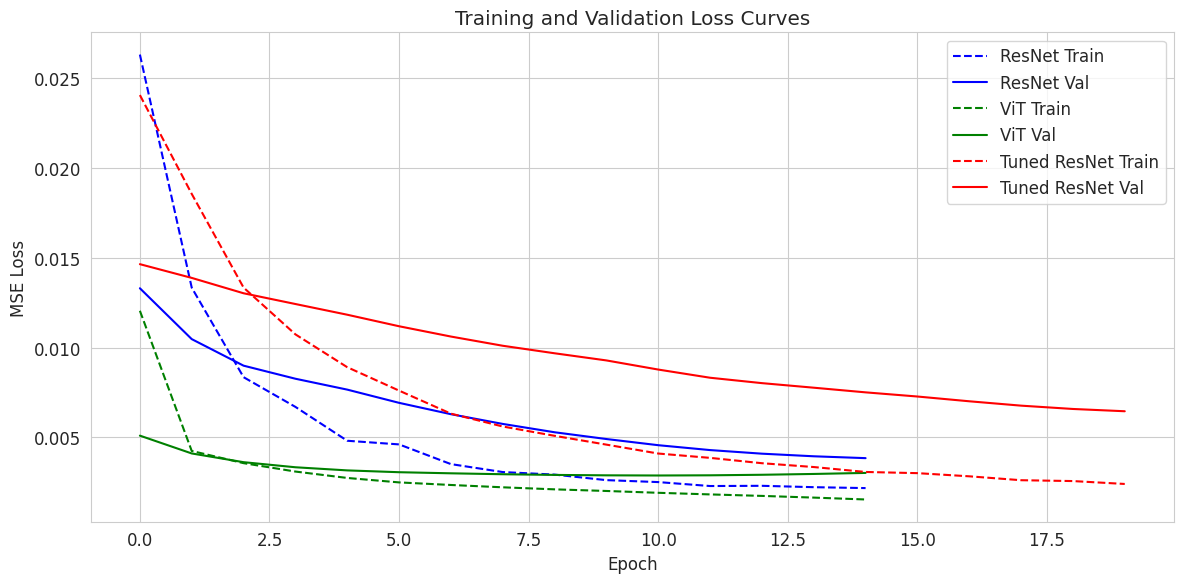

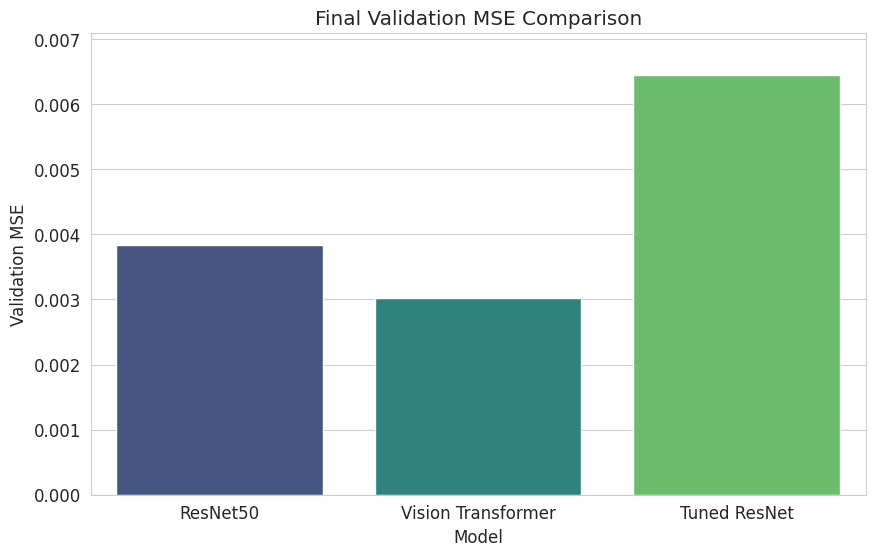


=== Model Performance Comparison ===
                Model  Validation MSE  Training Epochs
0            ResNet50        0.003841               15
1  Vision Transformer        0.003017               15
2        Tuned ResNet        0.006454               20


In [13]:
# Effect comparison plot and data generation
# Setting the drawing style
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 12

# Comparison of training curves
def plot_training_curves():
    plt.figure(figsize=(12, 6))
    
    # ResNet curve
    plt.plot(resnet_train_loss, label='ResNet Train', linestyle='--', color='blue')
    plt.plot(resnet_val_loss, label='ResNet Val', color='blue')
    
    # ViT curve
    plt.plot(vit_train_loss, label='ViT Train', linestyle='--', color='green')
    plt.plot(vit_val_loss, label='ViT Val', color='green')
    
    # The tuned ResNet curve
    plt.plot(final_train_loss, label='Tuned ResNet Train', linestyle='--', color='red')
    plt.plot(final_val_loss, label='Tuned ResNet Val', color='red')
    
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.tight_layout()
    plt.savefig('training_curves.png', dpi=300)
    plt.show()

plot_training_curves()
# print('ResNet Train',resnet_train_loss)
# print('ResNet Val',resnet_val_loss)

# print('ViT Train',vit_train_loss)
# print('ViT Val',vit_val_loss)

# print('Tuned ResNet Train',final_train_loss)
# print('Tuned ResNet Val',final_val_loss)

# Validation set performance comparison (table + bar chart)
def performance_comparison():
    # The final validation loss of each model is calculated
    resnet_final_loss = resnet_val_loss[-1]
    vit_final_loss = vit_val_loss[-1]
    tuned_resnet_final_loss = final_val_loss[-1]
    
    # Creating a comparison table
    performance_df = pd.DataFrame({
        'Model': ['ResNet50', 'Vision Transformer', 'Tuned ResNet'],
        'Validation MSE': [resnet_final_loss, vit_final_loss, tuned_resnet_final_loss],
        'Training Epochs': [15, 15, 20]
    })
    
    # Save it as CSV
    performance_df.to_csv('model_performance.csv', index=False)
    
    # Plot the bar chart
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Model', y='Validation MSE', data=performance_df, palette='viridis')
    plt.title('Final Validation MSE Comparison')
    plt.ylim(0, max(performance_df['Validation MSE']) * 1.1)
    plt.savefig('validation_comparison.png', dpi=300)
    plt.show()
    return performance_df

performance_df = performance_comparison()
print("\n=== Model Performance Comparison ===")
print(performance_df)

Number of validation set samples: 2
Validation set column name: ['imgId', 'prompt', 'prompt_length', 'embedding', 'img_path']

Generated test samples:
Image path: /kaggle/input/stable-diffusion-image-to-prompts/images/20057f34d.png
Prompt: hyper realistic photo of very friendly and dystopian crater

Image path: /kaggle/input/stable-diffusion-image-to-prompts/images/227ef0887.png
Prompt: ramen carved out of fractal rose ebony, in the style of hudson river school


=== ResNet generates examples ===


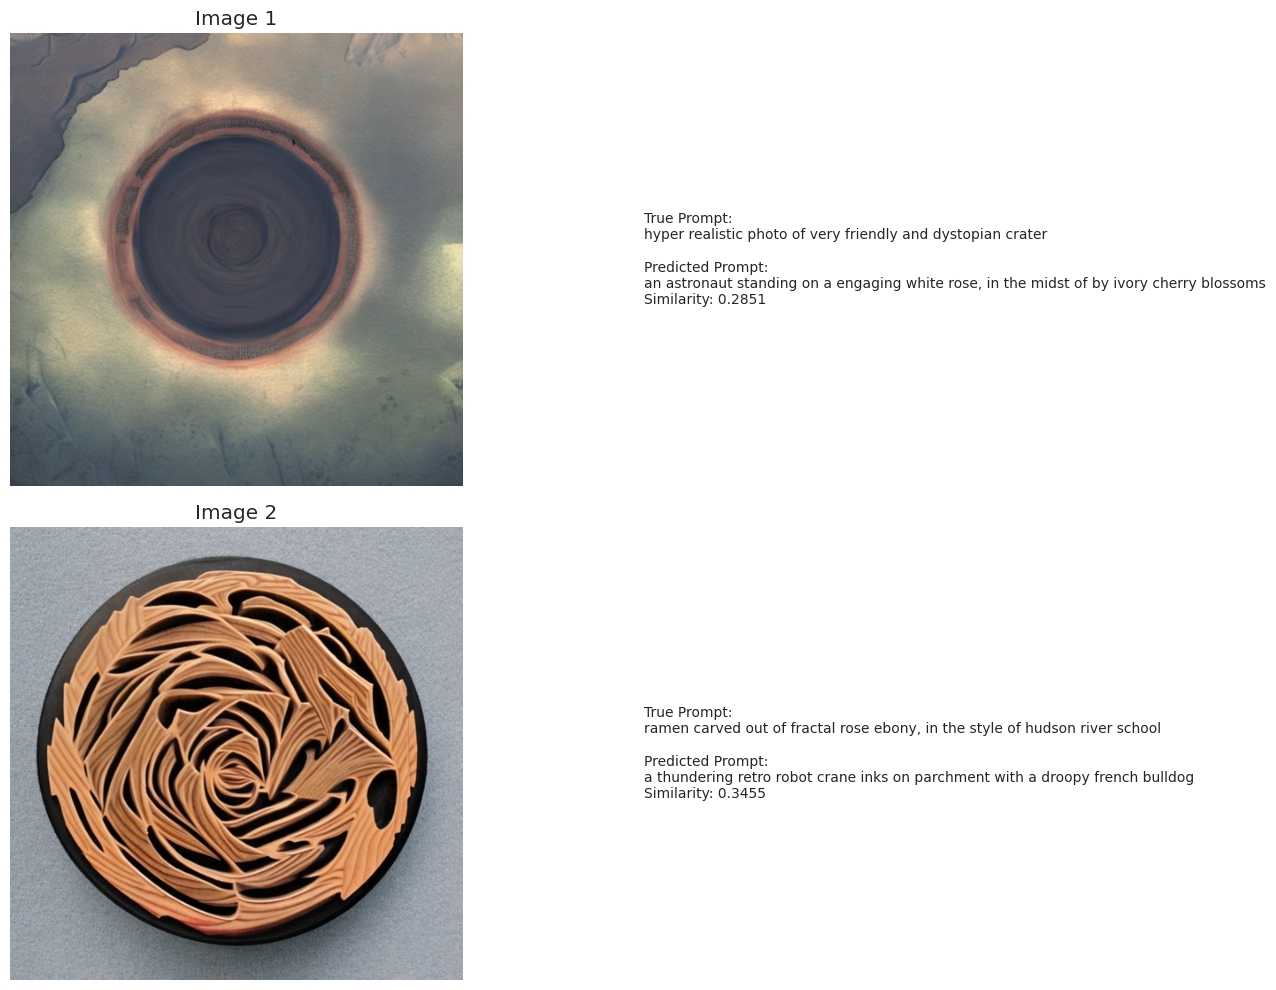


=== ViT generates examples ===


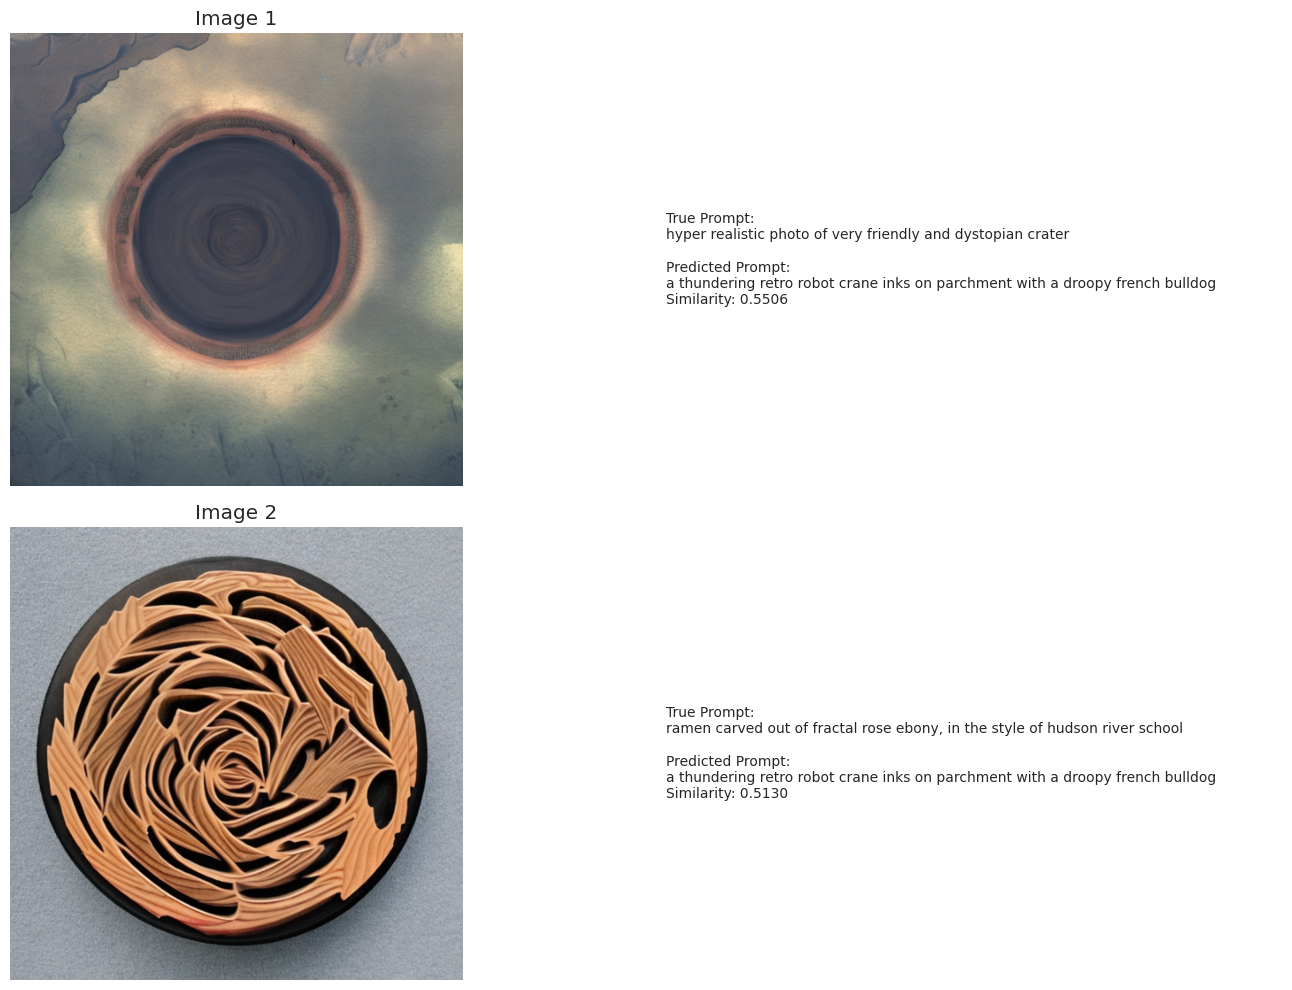


=== Tuning ResNet generation example ===


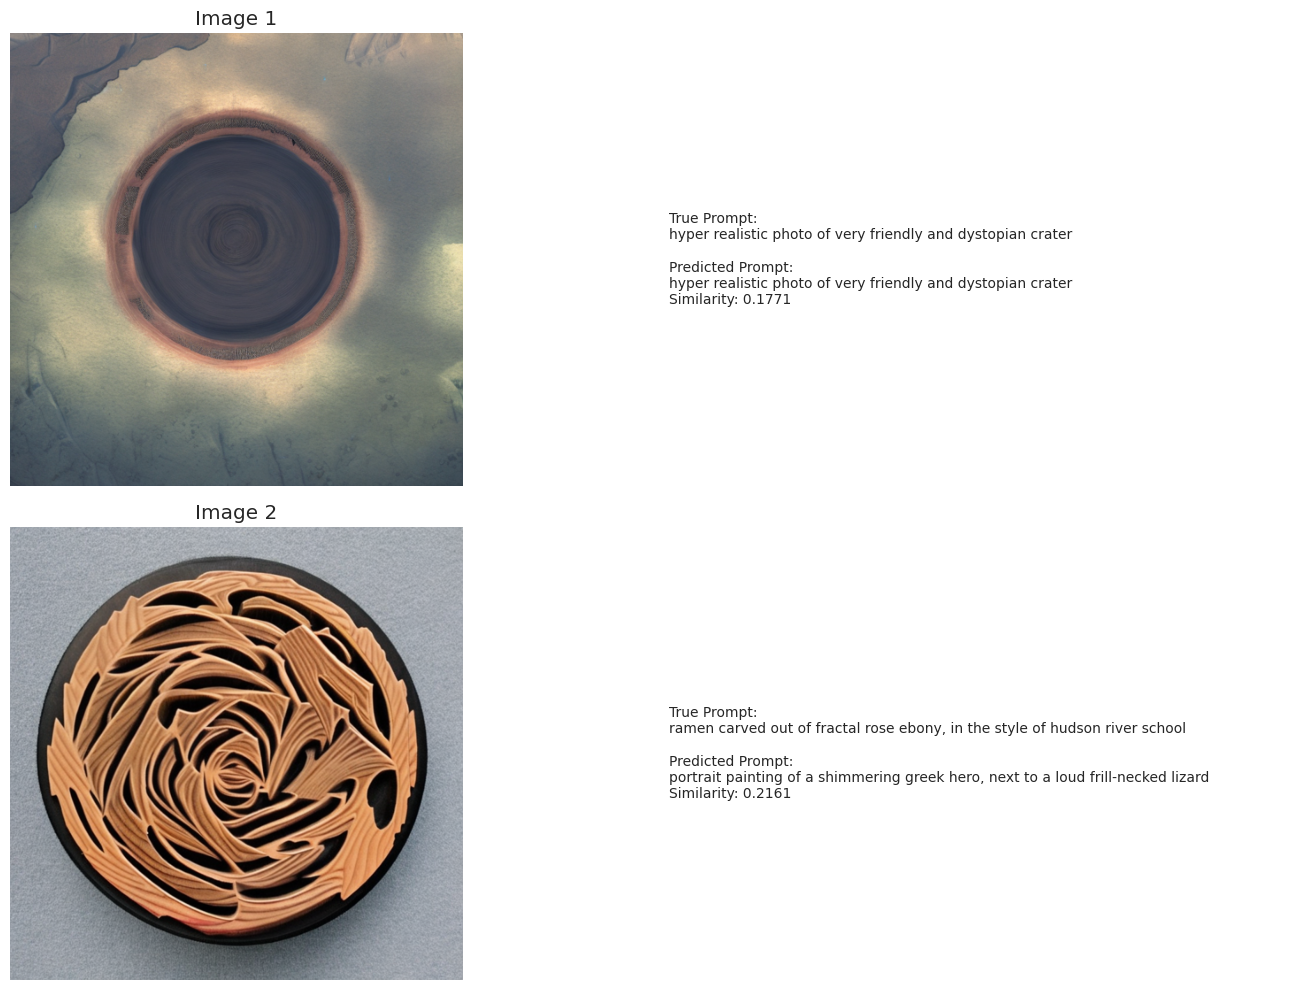


=== Similarity distribution analysis ===


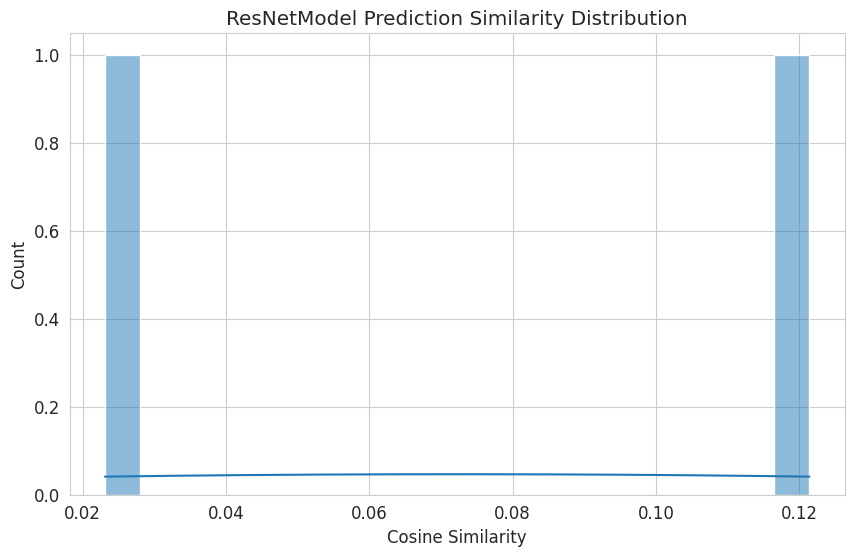

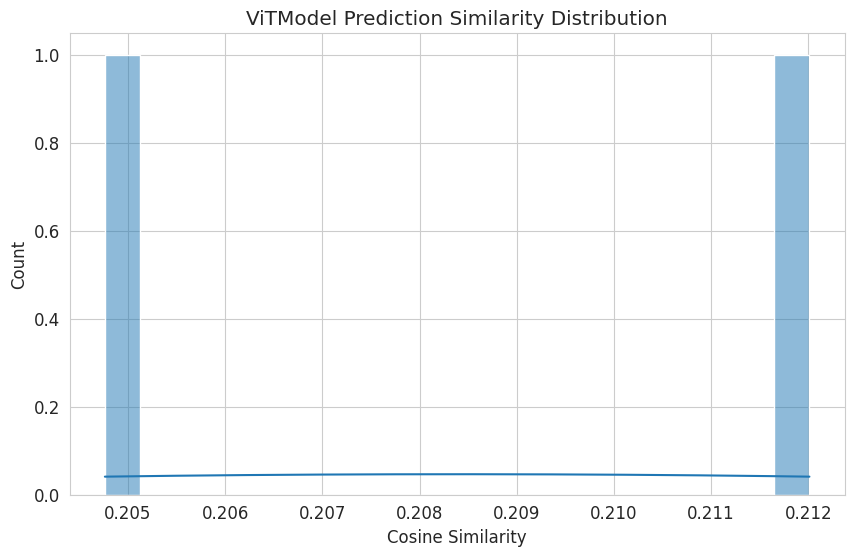

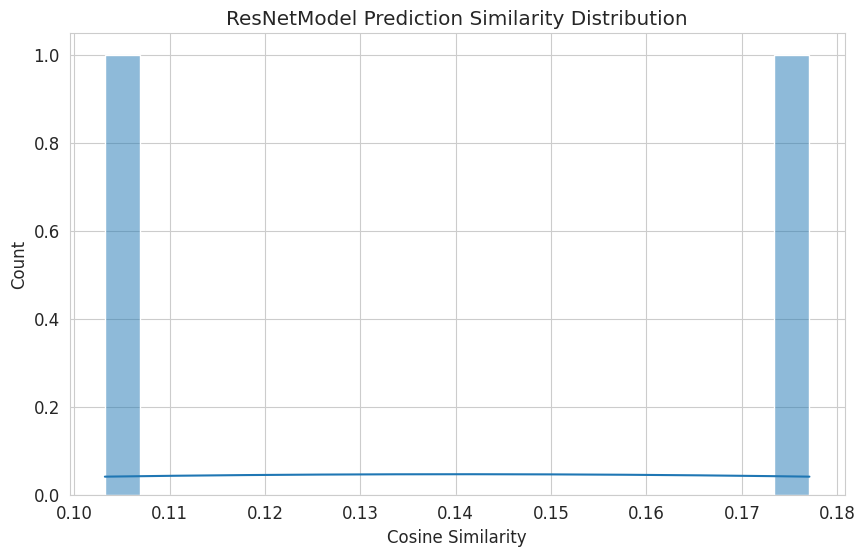

In [14]:
from torchvision import transforms

# A visualization of the generated example
def visualize_generation(model, image_paths, true_prompts, num_samples=3):
    plt.figure(figsize=(15, 5 * num_samples))
    
    for i, (img_path, true_prompt) in enumerate(zip(image_paths[:num_samples], true_prompts[:num_samples])):
        # Load the image and convert to a tensor
        image_pil = Image.open(img_path).convert('RGB')  # Get the PIL object
        transform = T.Compose([
            T.Resize((224, 224) if isinstance(model, ViTModel) else (256, 256)),
            T.ToTensor()  # Convert to tensor (shape [C, H, W])
        ])
        image_tensor = transform(image_pil)  # Applying transformations
        
        # Add the batch dimension and move to the device
        image_tensor = image_tensor.unsqueeze(0).to(device)  # You can now call unsqueeze
        
        # Forecasting
        with torch.no_grad():
            pred_embedding = model(image_tensor).cpu().numpy()
        
        # The rest of the code remains the same...
        similarities = cosine_similarity(pred_embedding, np.array(train_data['embedding'].tolist()))
        closest_idx = np.argmax(similarities)
        pred_prompt = train_data.iloc[closest_idx]['prompt']
        similarity_score = similarities[0][closest_idx]
        
        # Draw images and text
        ax = plt.subplot(num_samples, 2, 2*i+1)
        ax.imshow(image_pil)  # Display directly using the PIL object
        ax.axis('off')
        ax.set_title(f"Image {i+1}")
        
        ax = plt.subplot(num_samples, 2, 2*i+2)
        text = f"True Prompt:\n{true_prompt}\n\nPredicted Prompt:\n{pred_prompt}\nSimilarity: {similarity_score:.4f}"
        ax.text(0.1, 0.5, text, fontsize=10, va='center')
        ax.axis('off')
    
    plt.tight_layout()
    plt.savefig('generation_examples.png', dpi=150, bbox_inches='tight')
    plt.show()

# Selecting test samples
print(f"Number of validation set samples: {len(val_df)}")
# Make sure to include 'img_path' and 'prompt'
print(f"Validation set column name: {val_df.columns.tolist()}") 

# Safely generate test samples
n_samples = min(3, len(val_df))
test_samples = [
    (os.path.join(image_dir, val_df.iloc[i]['img_path']),
     val_df.iloc[i]['prompt'])
    for i in range(n_samples)
]

# Print the generated samples
print("\nGenerated test samples:")
for img_path, prompt in test_samples:
    print(f"Image path: {img_path}")
    print(f"Prompt: {prompt}\n")

print("\n=== ResNet generates examples ===")
visualize_generation(model_resnet, [s[0] for s in test_samples], [s[1] for s in test_samples])

print("\n=== ViT generates examples ===")
visualize_generation(model_vit, [s[0] for s in test_samples], [s[1] for s in test_samples])

print("\n=== Tuning ResNet generation example ===")
visualize_generation(final_model, [s[0] for s in test_samples], [s[1] for s in test_samples])

# Histogram of similarity distribution
def similarity_distribution(model, data_loader):
    similarities = []
    model.eval()
    with torch.no_grad():
        for images, true_embeddings in data_loader:
            images = images.to(device)
            pred_embeddings = model(images).cpu().numpy()
            true_embeddings = true_embeddings.numpy()
            
            batch_similarities = cosine_similarity(pred_embeddings, true_embeddings).diagonal()
            similarities.extend(batch_similarities)
    
    plt.figure(figsize=(10, 6))
    sns.histplot(similarities, bins=20, kde=True)
    plt.xlabel('Cosine Similarity')
    plt.title(f'{model.__class__.__name__} Prediction Similarity Distribution')
    plt.savefig(f'similarity_dist_{model.__class__.__name__}.png', dpi=300)
    plt.show()

print("\n=== Similarity distribution analysis ===")
similarity_distribution(model_resnet, val_loader_resnet)
similarity_distribution(model_vit, val_loader_vit)
similarity_distribution(final_model, final_val_loader)

## Generate some sample images


Image: d8edf2e40.png


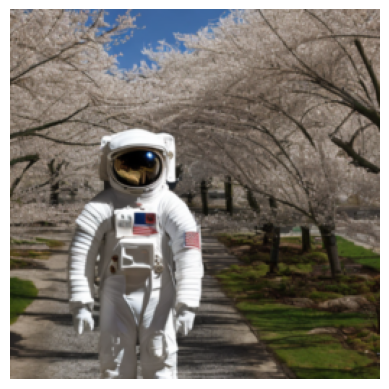

Top 1 Prompt: an astronaut standing on a engaging white rose, in the midst of by ivory cherry blossoms
Similarity: 0.5116

Top 2 Prompt: a thundering retro robot crane inks on parchment with a droopy french bulldog
Similarity: 0.1745

Top 3 Prompt: portrait painting of a shimmering greek hero, next to a loud frill-necked lizard
Similarity: 0.1599



In [15]:
def predict_prompt(model, image_path, top_k=3):
    # Preprocessing images
    transform = T.Compose([
        T.Resize((256, 256)),
        T.ToTensor()
    ])
    image = transform(Image.open(image_path).convert('RGB')).unsqueeze(0).to(device)
    
    # Predictive embedding
    with torch.no_grad():
        pred_embedding = model(image).cpu().numpy()

    # Find the most similar cue words
    similarities = cosine_similarity(pred_embedding, np.array(train_data['embedding'].tolist()))
    top_indices = similarities.argsort()[0][-top_k:][::-1]
    
    print(f"\nImage: {os.path.basename(image_path)}")
    plt.imshow(image.squeeze(0).cpu().permute(1, 2, 0).numpy())  
    plt.axis("off")
    plt.show()
    for i, idx in enumerate(top_indices):
        print(f"Top {i+1} Prompt: {train_data.iloc[idx]['prompt']}")
        print(f"Similarity: {similarities[0][idx]:.4f}\n")

# Test examples
test_image = os.path.join(image_dir, train_df.iloc[0]['img_path'])
predict_prompt(model_resnet, test_image)

In [16]:
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16) 
# Move pipeline to GPU
pipe = pipe.to("cuda")

def image_grid(imgs, rows, cols):
    "src: https://huggingface.co/blog/stable_diffusion"
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

safety_checker%2Fconfig.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer%2Fmerges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)ure_extractor%2Fpreprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

text_encoder%2Fconfig.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

(…)oints%2Fscheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

scheduler%2Fscheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

tokenizer%2Ftokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer%2Fspecial_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

unet%2Fconfig.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vae%2Fconfig.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

tokenizer%2Fvocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

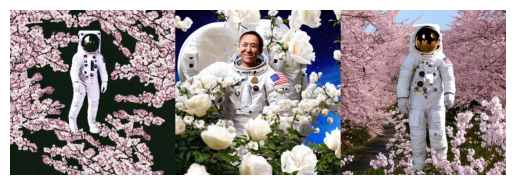

In [17]:
N = 3
prompt = ["an astronaut standing on a engaging white rose, in the midst of by ivory cherry blossoms"] * N

# Generate images
images = pipe(prompt).images

# Display images in a grid
grid = image_grid(images, rows=1, cols=3)
plt.imshow(grid)
plt.axis("off")
plt.show()